# 05 Time Series forecast with KNRegressor

KNRegressor is a distance based non-parametric etimator. It estimates the values of each point in a test set by examining the k-neares points in the training set based on a distance metric and calculating the mean.

I read the data after the preliminary EDA performed as part of the project proposal.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
import sklearn.metrics

I read the training and the test set.

In [3]:
X_tr_valid = np.load('X_tr_imputed.npy')
y_tr_valid = np.load('y_tr.npy')

# X_valid = np.load('features_valid.npy')
# y_valid = np.load('labels_valid.npy')

X_test = np.load('X_te_imputed.npy')
y_test = np.load('y_te.npy')

In [4]:
df_tr = pd.read_pickle('training_dataset_df.csv')

In [5]:
# qt_columns = ['SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'WSPM', 'PM10']
qt_columns = [6,7,8,9,10,11,12,15,16] # column indexes
qt = QuantileTransformer(n_quantiles = 1000, random_state = 0)

In [6]:
y_tr_valid_qt = qt.fit_transform(y_tr_valid.reshape(-1, 1))[:,0]
y_tr_valid_qt.shape

(30704,)

I define the error functions

In [6]:
# Mean Absolute error (MAE)
def MAE(y,y_pred):    
    return(np.mean(np.abs(y-y_pred)))

def MSE(y, y_pred):
    return np.mean(np.square(y - y_pred))


# Invert log-transformation and compute model error  -- not nneeded if quantile transformation used for target vector
def model_error(y,y_pred):
    # score = MAE(np.exp(y),np.exp(y_pred)) # Invert log-transformation and compute MAE
    score = MAE(y, y_pred) # invert QuantileTransformation
    # y_test does not need to be transformed
    return score

def RSS(y,y_pred):
    # score = MAE(np.exp(y),np.exp(y_pred)) # Invert log-transformation and compute MAE 
    # score = RSS(y_test, qt.inverse_transform(y_pred)) # invert QuantileTransformation
    score = np.sum(np.square(y - y_pred))# invert QuantileTransformation
    # y_test does not need to be transformed
    return score


def R2_score(y,y_pred, y_train):
    score = 1-(RSS(y, y_pred)/RSS(y,y_train.mean()))
    return score          

the data training/valid and test data have One-Hot-Encoding for all the categorical features. I define my preprocessor for the rest of the preprocessing and the quantile transformation selectively for specific columns  'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'WSPM', 'PM10' as well as the target vector 'PM2.5'. Then the pipeline will include the preprocessor and the model-fitting with the kNRegressor. I will scale the data before using the KNRegressor as it is a distance-based estimator. Anyway it is a good practise to scale the features as the chances for the estimator to converge to a global minimum error (not a local one) are better with scaling. 

In [7]:
# qt_columns = ['SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'WSPM', 'PM10']
qt_columns = [6,7,8,9,10,11,12,15,16] # column indexes
qt = QuantileTransformer(n_quantiles = 1000, random_state = 0)

In [8]:
y_tr_valid.shape

(30704,)

In [9]:
y_tr_valid_qt = qt.fit_transform(y_tr_valid.reshape(-1, 1))[:,0]
y_tr_valid_qt.shape

(30704,)

In [10]:
q = qt.fit_transform(y_tr_valid.reshape(-1, 1))
q.shape

(30704, 1)

In [11]:
y_tr_valid_qt2 = pd.Series(qt.fit_transform(np.array(y_tr_valid).reshape(-1, 1))[:,0])
y_tr_valid_qt2.shape

(30704,)

In [12]:
y_tr_valid_qt = qt.fit_transform(y_tr_valid.reshape(-1, 1))[:,0]

# if need be:
y_test_qt = qt.transform(y_test.reshape(-1, 1))[:,0]

I define my preprocessor for the quantile transformer for specific columns. The kNRegressor does not need to set the random-state because since it does not use any kind of random selection.

In [13]:
knn_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('preprocessor', ColumnTransformer([('quantile', qt, qt_columns)], remainder='passthrough')),
    ('knnreg', KNeighborsRegressor(algorithm = 'ball_tree', weights = 'distance')) # Grid search needed
])

In [14]:
knn_pipe.named_steps

{'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'preprocessor': ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
          transformer_weights=None,
          transformers=[('quantile', QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
           output_distribution='uniform', random_state=0, subsample=100000), [6, 7, 8, 9, 10, 11, 12, 15, 16])]),
 'knnreg': KNeighborsRegressor(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')}

I define a grid for the hyperparameters I want to fine tune.

In [15]:
grid = { 
         'knnreg__n_neighbors' : np.arange(1,50,10),
         'knnreg__p': [1,2]  #p=1: Manhattan distance, p=2 euklidean distance
       }

With time series data we have to preserve the chronological order of observations because of their temporal dependency (autocorrelation). We cannot shuffle the data so we can only learn from the past and predict the future, not the other way around. That means that the training set will always precede the validation set. If we choose one validation set we do not know if it is representative of what we would observe in the future. Therefore k-fold cross-validation comes into play to reduce the bias of an ML model estimation of the prediction error. Moreover the final score will be the average of scores obtained in each fold. This reduces overfitting and constitutes a more robust way of model evaluation. I will use the TimeSeriesSplit to split the time series training set in rolling k = 4 folds.

In [16]:
tscv = TimeSeriesSplit(n_splits = 4)

In [17]:
tscv.split(X_tr_valid)
for train_index, valid_index in tscv.split(X_tr_valid, y_tr_valid_qt):
    print(train_index, valid_index)

[   0    1    2 ... 6141 6142 6143] [ 6144  6145  6146 ... 12281 12282 12283]
[    0     1     2 ... 12281 12282 12283] [12284 12285 12286 ... 18421 18422 18423]
[    0     1     2 ... 18421 18422 18423] [18424 18425 18426 ... 24561 24562 24563]
[    0     1     2 ... 24561 24562 24563] [24564 24565 24566 ... 30701 30702 30703]


In [18]:
tscv.get_n_splits()

4

In [19]:
for train_index, valid_index in tscv.split(X_tr_valid, y_tr_valid_qt):
    X_train, X_valid = X_tr_valid[train_index], X_tr_valid[valid_index]
    y_train, y_valid = y_tr_valid_qt[train_index], y_tr_valid_qt[valid_index]

After generating the k-folds I will use the GridSearchCV to do the grid search for hyperparameter tuning.

In [20]:
grid_cv = GridSearchCV(knn_pipe, grid, cv = tscv, return_train_score = True, verbose = 1, n_jobs = -1)

In [21]:
y_tr_valid_qt.shape

(30704,)

### Grid search first run

In [22]:
grid_cv.fit(X_tr_valid, y_tr_valid_qt)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  6.7min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=4),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('preprocessor', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('quantile', QuantileTransformer(copy=True, ignore_implicit_zeros=Fals...ski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='distance'))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'knnreg__n_neighbors': array([ 1, 11, 21, 31, 41]), 'knnreg__p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [23]:
grid_cv.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('preprocessor', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('quantile', QuantileTransformer(copy=True, ignore_implicit_zeros=Fals...ki',
          metric_params=None, n_jobs=None, n_neighbors=41, p=1,
          weights='distance'))])

In [24]:
grid_cv.cv_results_

{'mean_fit_time': array([0.45097065, 0.45402902, 0.44537133, 0.47305161, 0.46195459,
        0.4831416 , 0.47793543, 0.47213352, 0.51487768, 0.4669522 ]),
 'std_fit_time': array([0.19772217, 0.19327824, 0.25256096, 0.24777267, 0.21687374,
        0.19753894, 0.21562156, 0.22217275, 0.25658933, 0.20368482]),
 'mean_score_time': array([15.56879205, 16.75757825, 18.63684165, 19.4344129 , 19.51835036,
        19.72650844, 19.88150054, 19.49981302, 19.29568362, 18.13341331]),
 'std_score_time': array([7.40400966, 8.34684206, 9.42374376, 9.28807627, 9.11763927,
        9.72329481, 9.30202447, 9.22996779, 8.92740542, 8.14622454]),
 'param_knnreg__n_neighbors': masked_array(data=[1, 1, 11, 11, 21, 21, 31, 31, 41, 41],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_knnreg__p': masked_array(data=[1, 2, 1, 2, 1, 2, 1, 2, 1, 2],
              mask=[False, False, False, False,

In [25]:
grid_cv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_knnreg__n_neighbors', 'param_knnreg__p', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'mean_train_score', 'std_train_score'])

In [27]:
cv_results = pd.DataFrame(grid_cv.cv_results_)
cols = ['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'param_knnreg__n_neighbors', 'param_knnreg__p']
cv_results[cols].sort_values(by = 'mean_test_score', ascending = False).head()

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_knnreg__n_neighbors,param_knnreg__p
8,0.845213,0.017241,1.0,0.0,41,1
6,0.844862,0.018413,1.0,0.0,31,1
4,0.843855,0.019001,1.0,0.0,21,1
2,0.836370,0.019344,1.0,0.0,11,1
5,0.738155,0.037010,1.0,0.0,21,2


In [28]:
grid_cv.best_estimator_.steps

[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('preprocessor',
  ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
           transformer_weights=None,
           transformers=[('quantile', QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
            output_distribution='uniform', random_state=0, subsample=100000), [6, 7, 8, 9, 10, 11, 12, 15, 16])])),
 ('knnreg',
  KNeighborsRegressor(algorithm='ball_tree', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=None, n_neighbors=41, p=1,
            weights='distance'))]

In [29]:
grid_cv.cv_results_['mean_test_score']

array([0.70414551, 0.56198795, 0.83636981, 0.73410798, 0.84385499,
       0.73815496, 0.84486207, 0.73805912, 0.84521294, 0.73746332])

### Grid search refinement: metric R2

I will now finetune my hyperparameter grid search, fixing the following parameters: 
 - weights = 'distance'. in this case, points are weighted by the inverse of their distance that means that closer neighbors of a query point will have a greater influence than neighbors which are further away.
 - power parameter p for the Minkowski metric p = 1, this is equivalent to using manhattan_distance,
 - and algorithm = 'ball tree'.
 
 I will optimize b ased on the number of neighbor points.

In [30]:
knn_pipe2 = Pipeline([
    ('scaler', StandardScaler()), 
    ('preprocessor', ColumnTransformer([('quantile', qt, qt_columns)], remainder='passthrough')),
    ('knnreg', KNeighborsRegressor(algorithm = 'ball_tree', p = 1, weights = 'distance')) # Grid search needed for k_neighbors
])

In [31]:
grid2 = { 
         'knnreg__n_neighbors' : np.arange(1,50,1)
        }

In [32]:
grid_cv2 = GridSearchCV(knn_pipe2, grid2, cv = tscv, return_train_score = True, verbose = 1, n_jobs = -1)
grid_cv2.fit(X_tr_valid, y_tr_valid_qt)

Fitting 4 folds for each of 49 candidates, totalling 196 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 196 out of 196 | elapsed: 31.8min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=4),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('preprocessor', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('quantile', QuantileTransformer(copy=True, ignore_implicit_zeros=Fals...ski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=1,
          weights='distance'))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'knnreg__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [34]:
cv_results2 = pd.DataFrame(grid_cv2.cv_results_)
cols = ['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'param_knnreg__n_neighbors']
cv_results2[cols].sort_values(by = 'mean_test_score', ascending = False).head()

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_knnreg__n_neighbors
35,0.845426,0.017761,1.0,0.0,36
34,0.845422,0.017890,1.0,0.0,35
36,0.845376,0.017581,1.0,0.0,37
37,0.845296,0.017540,1.0,0.0,38
39,0.845264,0.017297,1.0,0.0,40


In [35]:
mean_train = cv_results2['mean_train_score']
mean_test = cv_results2['mean_test_score']
std_train = cv_results2['std_train_score']
std_test = cv_results2['std_test_score']

In [36]:
(mean_test - std_test).dtype

dtype('float64')

In [37]:
std_test.dtype

dtype('float64')

In [38]:
std_plus = np.array((mean_test + std_test), dtype = float)
std_minus = np.array((mean_test - std_test), dtype = float)

In [39]:
std_plus

array([0.75074791, 0.80103212, 0.82268541, 0.83323109, 0.83927137,
       0.8447316 , 0.84805459, 0.85089455, 0.85286379, 0.85407242,
       0.85571351, 0.85727839, 0.85790382, 0.8591189 , 0.86005209,
       0.86091529, 0.8615921 , 0.86197487, 0.86272217, 0.86277405,
       0.86285589, 0.86297229, 0.86303848, 0.86326277, 0.86342435,
       0.86354397, 0.8635166 , 0.86352308, 0.8633194 , 0.86328528,
       0.86327541, 0.86329163, 0.86326726, 0.86330183, 0.86331204,
       0.86318663, 0.86295684, 0.86283661, 0.86267656, 0.86256078,
       0.86245399, 0.86244978, 0.86212277, 0.86211104, 0.86207624,
       0.86196866, 0.8617312 , 0.86163336, 0.86165555])

In [40]:
np.isfinite(std_plus)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [41]:
std_minus

array([0.65754311, 0.73968171, 0.77100241, 0.78498932, 0.79589815,
       0.80197012, 0.80718597, 0.81005849, 0.81338862, 0.8152301 ,
       0.81702612, 0.81839431, 0.8191442 , 0.8199674 , 0.8212144 ,
       0.82183402, 0.82273053, 0.82334371, 0.82385048, 0.82445096,
       0.82485408, 0.82491117, 0.82486004, 0.82536766, 0.8254577 ,
       0.82569218, 0.82606446, 0.82639899, 0.82662779, 0.82654477,
       0.82644872, 0.82672399, 0.82705966, 0.82710715, 0.82753132,
       0.8276648 , 0.82779582, 0.82775604, 0.82784245, 0.82796685,
       0.8279719 , 0.82796316, 0.82811899, 0.82812586, 0.8282892 ,
       0.82825499, 0.82818025, 0.82821698, 0.82820559])

In [42]:
np.isfinite(std_minus)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [43]:
std_plus - std_minus

array([0.0932048 , 0.06135041, 0.051683  , 0.04824177, 0.04337321,
       0.04276149, 0.04086862, 0.04083606, 0.03947518, 0.03884232,
       0.03868739, 0.03888408, 0.03875963, 0.0391515 , 0.03883769,
       0.03908127, 0.03886157, 0.03863116, 0.03887169, 0.03832309,
       0.03800181, 0.03806112, 0.03817844, 0.03789512, 0.03796665,
       0.03785179, 0.03745214, 0.03712408, 0.03669161, 0.03674051,
       0.03682669, 0.03656763, 0.03620761, 0.03619468, 0.03578072,
       0.03552183, 0.03516102, 0.03508057, 0.03483411, 0.03459393,
       0.03448209, 0.03448661, 0.03400378, 0.03398518, 0.03378704,
       0.03371368, 0.03355095, 0.03341638, 0.03344995])

In [44]:
k = cv_results2['param_knnreg__n_neighbors']
k

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    17
17    18
18    19
19    20
20    21
21    22
22    23
23    24
24    25
25    26
26    27
27    28
28    29
29    30
30    31
31    32
32    33
33    34
34    35
35    36
36    37
37    38
38    39
39    40
40    41
41    42
42    43
43    44
44    45
45    46
46    47
47    48
48    49
Name: param_knnreg__n_neighbors, dtype: object

In [45]:
best_k = 36

In [46]:
index = mean_test.idxmax()
best_k = cv_results2['param_knnreg__n_neighbors'][index]
best_k

36

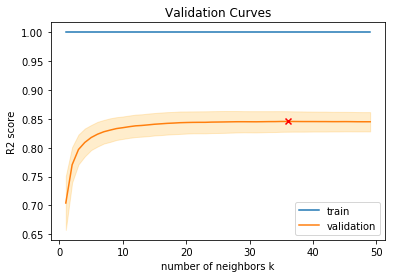

In [47]:
plt.plot(cv_results2['param_knnreg__n_neighbors'], cv_results2['mean_train_score'], label = 'train')
plt.plot(cv_results2['param_knnreg__n_neighbors'], cv_results2['mean_test_score'], label = 'validation')
plt.scatter(best_k, cv_results2['mean_test_score'].max(), marker='x', c='red', zorder=10)
# k has to transformed to float otherwise error is thrown therefore: np.array(k,dtype = float)
plt.fill_between(np.array(k,dtype = float), std_minus, std_plus, alpha=0.2, color = 'orange')
plt.title('Validation Curves')
plt.xlabel('number of neighbors k')
plt.ylabel('R2 score')
plt.legend()
plt.show()

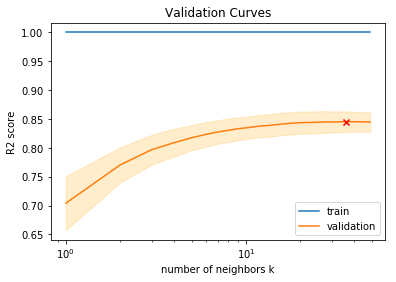

In [48]:
plt.semilogx(cv_results2['param_knnreg__n_neighbors'], cv_results2['mean_train_score'], label = 'train')
plt.semilogx(cv_results2['param_knnreg__n_neighbors'], cv_results2['mean_test_score'], label = 'validation')
# k has to be transformed to float otherwise error is thrown therefore: np.array(k,dtype = float)
plt.fill_between(np.array(k,dtype = float), std_minus, std_plus, alpha=0.2, color = 'orange')
plt.scatter(best_k, cv_results2['mean_test_score'].max(), marker='x', c='red', zorder=10)
plt.title('Validation Curves')
plt.xlabel('number of neighbors k')
plt.ylabel('R2 score')
plt.legend()
plt.show()

### Grid search refinement: metric MAE

I will now refine my gridsearch using a different metric, Mean Absolute Error (MAE).

In [49]:
knn_pipe3 = Pipeline([
    ('scaler', StandardScaler()), 
    ('preprocessor', ColumnTransformer([('quantile', qt, qt_columns)], remainder='passthrough')),
    ('knnreg', KNeighborsRegressor(algorithm = 'ball_tree', p = 1, weights = 'distance')) # Grid search needed for k_neighbors
])

In [50]:
grid3 = { 
         'knnreg__n_neighbors' : np.arange(1,50,1)
        }

In [52]:
grid_cv3 = GridSearchCV(knn_pipe3, grid3, cv = tscv, return_train_score = True, verbose = 1, n_jobs = -1, scoring = 'neg_mean_absolute_error')
grid_cv3.fit(X_tr_valid, y_tr_valid_qt)

Fitting 4 folds for each of 49 candidates, totalling 196 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 196 out of 196 | elapsed: 31.4min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=4),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('preprocessor', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('quantile', QuantileTransformer(copy=True, ignore_implicit_zeros=Fals...ski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=1,
          weights='distance'))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'knnreg__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

In [54]:
cv_results3 = pd.DataFrame(grid_cv3.cv_results_)
cols = ['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'param_knnreg__n_neighbors']
cv_results3[cols].sort_values(by = 'mean_test_score', ascending = False).head()

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_knnreg__n_neighbors
21,-0.084496,0.003339,0.0,0.0,22
20,-0.084502,0.003347,0.0,0.0,21
23,-0.084504,0.003329,0.0,0.0,24
18,-0.084506,0.003495,0.0,0.0,19
27,-0.084509,0.003165,0.0,0.0,28


I will revert the sign in order to have the MAE and not the NMAE.

In [56]:
cv_results3 = pd.DataFrame(grid_cv3.cv_results_)
cols = ['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'param_knnreg__n_neighbors']
cv_results3['mean_test_score'] = np.abs(cv_results3['mean_test_score'])
cv_results3['mean_train_score'] = np.abs(cv_results3['mean_train_score'])
cv_results3[cols].sort_values(by = 'mean_test_score', ascending = True).head(10)

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_knnreg__n_neighbors
21,0.084496,0.003339,0.0,0.0,22
20,0.084502,0.003347,0.0,0.0,21
23,0.084504,0.003329,0.0,0.0,24
18,0.084506,0.003495,0.0,0.0,19
27,0.084509,0.003165,0.0,0.0,28
19,0.084514,0.003385,0.0,0.0,20
24,0.084515,0.003313,0.0,0.0,25
25,0.084528,0.003250,0.0,0.0,26
26,0.084537,0.003191,0.0,0.0,27
28,0.084552,0.003111,0.0,0.0,29


I save the results of GridSearchCV.

In [57]:
np.save('knreg_cv_R2.csv', cv_results2)
np.save('knreg_cv_mae.csv', cv_results3)
cv_results3.head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knnreg__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.466388,0.208427,17.475776,8.129134,1,{'knnreg__n_neighbors': 1},-0.119431,-0.102727,-0.117507,-0.107373,0.111760,0.006941,49,-0.0,-0.0,-0.0,-0.0,0.0,0.0
1,0.470020,0.210543,17.903089,8.267833,2,{'knnreg__n_neighbors': 2},-0.105179,-0.093077,-0.104000,-0.096344,0.099650,0.005090,48,-0.0,-0.0,-0.0,-0.0,0.0,0.0
2,0.482932,0.227999,17.995901,8.114879,3,{'knnreg__n_neighbors': 3},-0.098237,-0.088158,-0.098182,-0.092158,0.094184,0.004267,47,-0.0,-0.0,-0.0,-0.0,0.0,0.0
3,0.470039,0.229809,17.768722,8.141037,4,{'knnreg__n_neighbors': 4},-0.094966,-0.085878,-0.095604,-0.089682,0.091533,0.003992,46,-0.0,-0.0,-0.0,-0.0,0.0,0.0


In [1]:
#cv_results3 = np.load('knreg_cv_mae.csv')

In [83]:
mean_train = cv_results3['mean_train_score']
mean_test = cv_results3['mean_test_score']
std_train = cv_results3['std_train_score']
std_test = cv_results3['std_test_score']
k = cv_results3['param_knnreg__n_neighbors']

std_plus = np.array((mean_test + std_test), dtype = float)
std_minus = np.array((mean_test - std_test), dtype = float)

In [77]:
index = mean_test.idxmin()
best_k = cv_results3['param_knnreg__n_neighbors'][index]
best_k

22

In [78]:
grid_cv.best_estimator_.steps

[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('preprocessor',
  ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
           transformer_weights=None,
           transformers=[('quantile', QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
            output_distribution='uniform', random_state=0, subsample=100000), [6, 7, 8, 9, 10, 11, 12, 15, 16])])),
 ('knnreg',
  KNeighborsRegressor(algorithm='ball_tree', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=None, n_neighbors=41, p=1,
            weights='distance'))]

In [79]:
grid_cv.best_estimator_.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('preprocessor', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('quantile', QuantileTransformer(copy=True, ignore_implicit_zeros=Fals...ki',
          metric_params=None, n_jobs=None, n_neighbors=41, p=1,
          weights='distance'))])>

In [80]:
scores = cv_results3[['mean_test_score',  'std_test_score', 'mean_train_score', 'std_train_score','param_knnreg__n_neighbors' ]]

In [81]:
scores.columns = ['MAE_test','std_test_score', 'MAE_train', 'std_train_score', 'k_neighbors']
scores.head()

,MAE_test,std_test_score,MAE_train,std_train_score,n_estimators
0,0.111760,0.006941,0.0,0.0,1
1,0.099650,0.005090,0.0,0.0,2
2,0.094184,0.004267,0.0,0.0,3
3,0.091533,0.003992,0.0,0.0,4
4,0.089826,0.003541,0.0,0.0,5


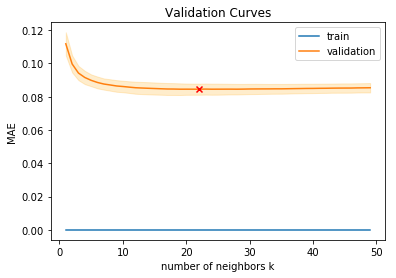

In [84]:
# plot validation curves
plt.plot(cv_results3['param_knnreg__n_neighbors'], cv_results3['mean_train_score'], label = 'train')
plt.plot(cv_results3['param_knnreg__n_neighbors'], cv_results3['mean_test_score'], label = 'validation')
plt.scatter(best_k, cv_results3['mean_test_score'].min(), marker='x', c='red', zorder=10)
# k has to transformed to float otherwise error is thrown therefore: np.array(k,dtype = float)
plt.fill_between(np.array(k, dtype = float), std_minus, std_plus, alpha=0.2, color = 'orange')
plt.title('Validation Curves')
plt.xlabel('number of neighbors k')
plt.ylabel('MAE')
plt.legend()
plt.show()

In this case it seems to perfectly predict the training set, which could indicate overfitting, but it happens for all k-values and both metrics (R2 and MAE). The validation error shows clearly an optimum value which I choose for the estimator.

### Make predictions

I will now use the optimum number of k neighbors previously found accordinng to MAE metric to make predictions.

In [86]:
knn_pipe_best = Pipeline([
    ('scaler', StandardScaler()), 
    ('preprocessor', ColumnTransformer([('quantile', qt, qt_columns)], remainder='passthrough')),
    ('knnreg', KNeighborsRegressor(n_neighbors = best_k, algorithm = 'ball_tree', p = 1, weights = 'distance'))
])

In [87]:
knn_pipe_best.fit(X_tr_valid, y_tr_valid_qt)
# predict
y_test_pred_qt = knn_pipe_best.predict(X_test)
# invert the quantile transformation
y_test_pred = qt.inverse_transform(y_test_pred_qt.reshape(-1, 1))[:,0]

In [89]:
KNNreg_mae = MAE(y_test, y_test_pred)
KNNreg_mae

23.811492124926772

In [90]:
r2 = R2_score(y_test, y_test_pred, y_tr_valid)
r2

0.8539017136101675

In [92]:
results_knnreg = {'model': ['KnnReg'], 'r2_score': r2, 'MAE': KNNreg_mae}
results_knnreg = pd.DataFrame(results_knnreg)
np.save('results_KnnReg', results_knnreg)
results_knnreg

,model,r2_score,MAE
0,KnnReg,0.853902,23.811492


### Ploting the predictions along with the real values

In [ ]:
y_test_df = pd.read_pickle('y_te.csv')
y_test_df = pd.DataFrame(y_test_df)
y_test_df['PM2.5 - prediction'] = y_test_pred
y_test_df['Residuals'] = y_test - y_test_pred
y_test_df.head()

I save the predictions of KNRegressor.

In [103]:
y_test_df.index

DatetimeIndex(['2016-09-01 00:00:00', '2016-09-01 01:00:00',
               '2016-09-01 02:00:00', '2016-09-01 03:00:00',
               '2016-09-01 04:00:00', '2016-09-01 05:00:00',
               '2016-09-01 06:00:00', '2016-09-01 07:00:00',
               '2016-09-01 08:00:00', '2016-09-01 09:00:00',
               ...
               '2017-02-28 14:00:00', '2017-02-28 15:00:00',
               '2017-02-28 16:00:00', '2017-02-28 17:00:00',
               '2017-02-28 18:00:00', '2017-02-28 19:00:00',
               '2017-02-28 20:00:00', '2017-02-28 21:00:00',
               '2017-02-28 22:00:00', '2017-02-28 23:00:00'],
              dtype='datetime64[ns]', name='Date and Time', length=4344, freq=None)

In [101]:
y_test_df.to_pickle('KNRegressor_predictions.csv')

In [8]:
y_test_df = pd.read_pickle('KNRegressor_predictions.csv')
y_test_df.head()

,PM2.5,PM2.5 - prediction,Residuals
Date and Time,,,
2016-09-01 00:00:00,12.0,11.000000,1.000000
2016-09-01 01:00:00,17.0,7.670028,9.329972
2016-09-01 02:00:00,3.0,8.000000,-5.000000
2016-09-01 03:00:00,8.0,7.000000,1.000000
2016-09-01 04:00:00,14.0,10.000000,4.000000


In [10]:
font_dict = {'fontname':'Arial', 'size':'16'}

In [11]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

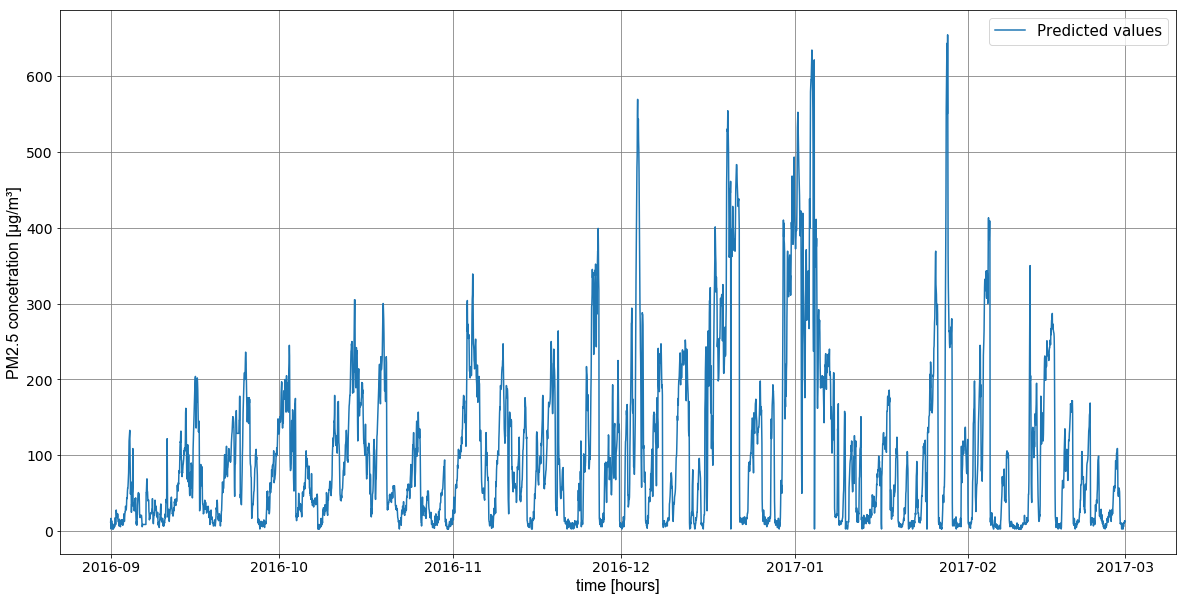

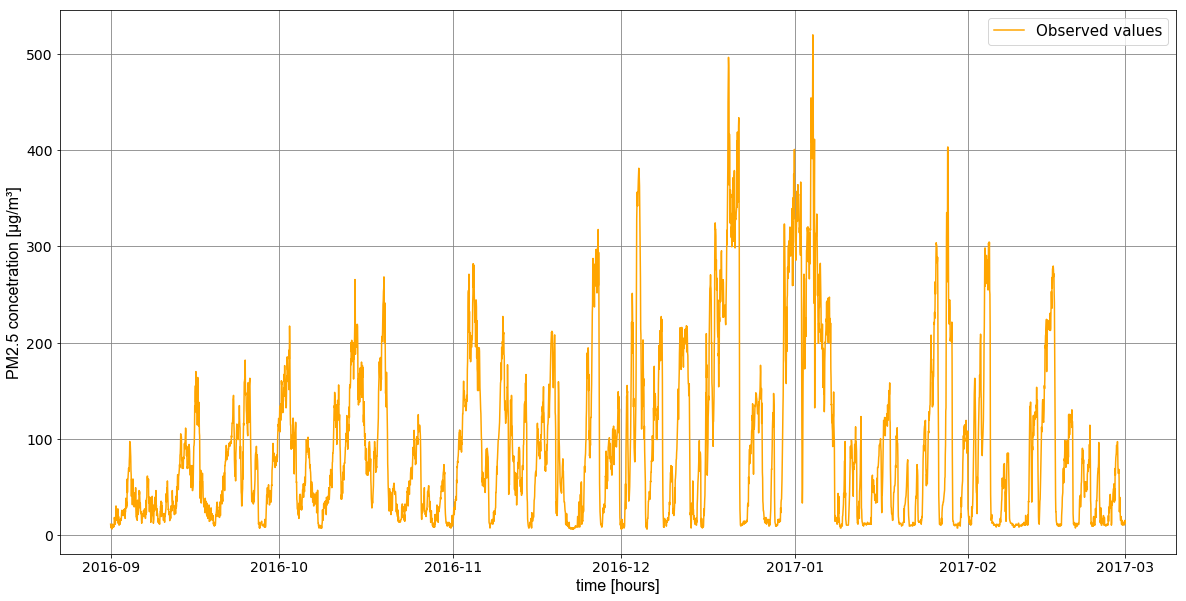

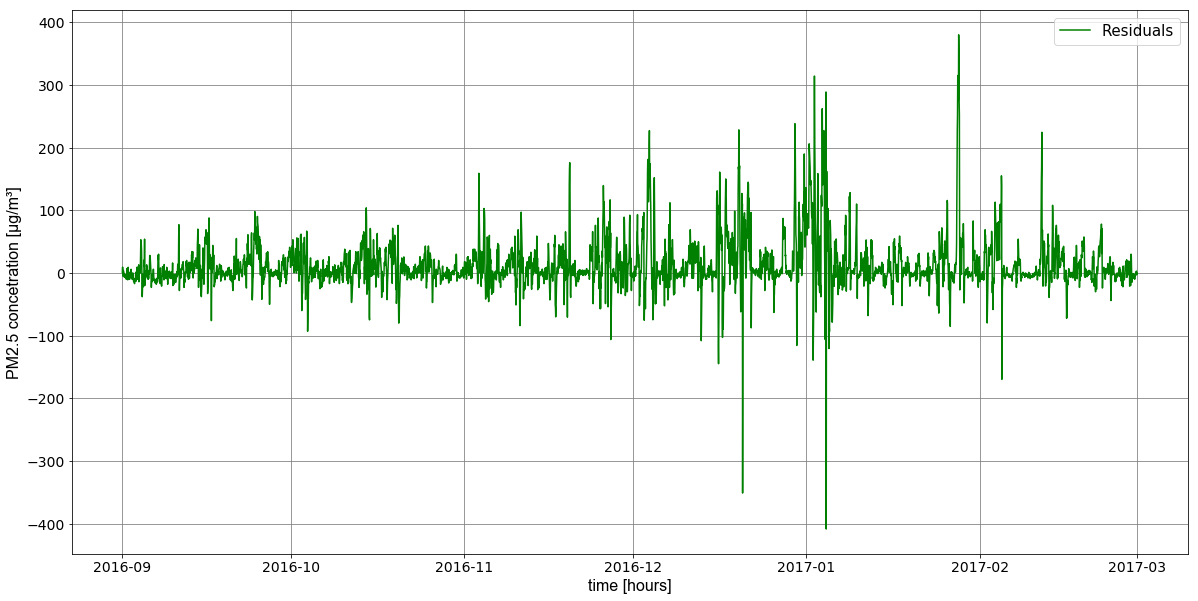

In [162]:
# plot Observations
plt.figure(figsize = (20,10))
plt.plot(y_test_df['PM2.5'], label = 'Predicted values')
plt.ylabel('PM2.5 concetration [µg/m³]', fontdict = font_dict)
plt.xlabel('time [hours]', fontdict = font_dict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={"size":15})
plt.grid(True)
plt.rc('grid', linestyle='-', color='grey')
plt.show()
# plot Predictions
plt.figure(figsize = (20,10))
plt.plot(y_test_df['PM2.5 - prediction'], color = 'orange', label = 'Observed values')
plt.ylabel('PM2.5 concetration [µg/m³]', fontdict = font_dict)
plt.xlabel('time [hours]', fontdict = font_dict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={"size":15})
plt.grid(True)
plt.rc('grid', linestyle='-', color='grey')
plt.show()
# plot Residuals
plt.figure(figsize = (20,10))
plt.plot(y_test_df['Residuals'], color = 'green', label = 'Residuals')
plt.ylabel('PM2.5 concetration [µg/m³]', fontdict = font_dict)
plt.xlabel('time [hours]', fontdict = font_dict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={"size":15})
plt.grid(True)
plt.rc('grid', linestyle='-', color='grey')
plt.show()

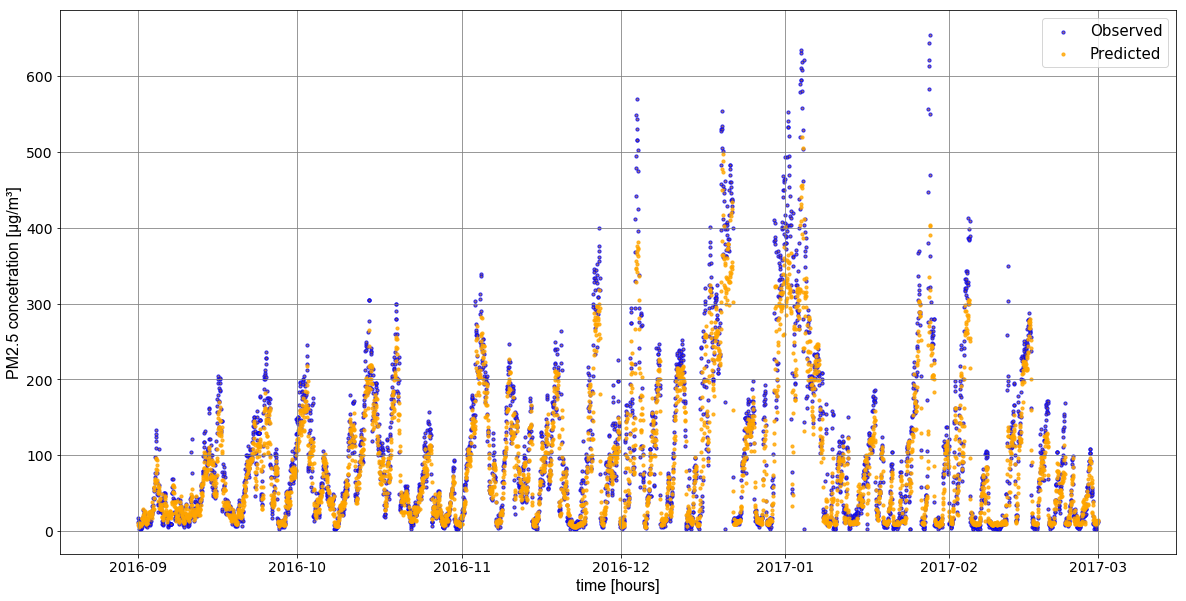

In [219]:
plt.figure(figsize = (20,10))
plt.scatter(y_test_df.index, y_test_df['PM2.5'], color = 'blue',  s=10, facecolors='C5', edgecolors='b', alpha = 0.8, label = 'Observed')
plt.scatter(y_test_df.index, y_test_df['PM2.5 - prediction'], color = 'orange', s=10, facecolors='orange', edgecolors='orange', alpha = 0.8, label = 'Predicted')
plt.ylabel('PM2.5 concetration [µg/m³]', fontdict = font_dict)
plt.xlabel('time [hours]', fontdict = font_dict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={"size":15})
plt.grid(True)
plt.rc('grid', linestyle='-', color='grey')
plt.show()

for better readability I will plot the prediction for one month.

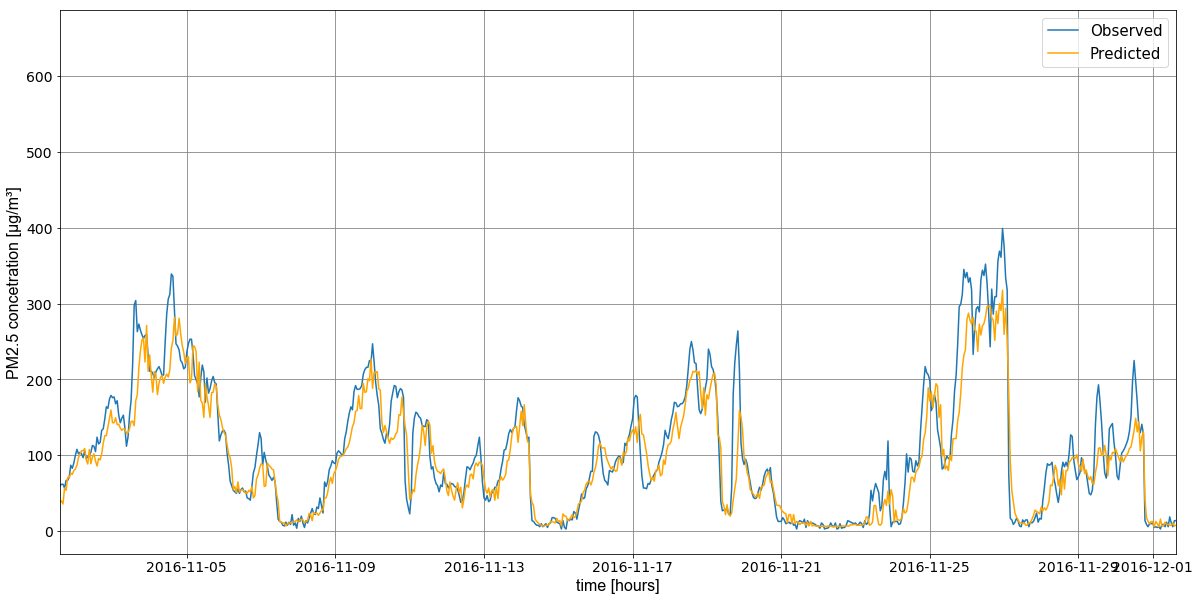

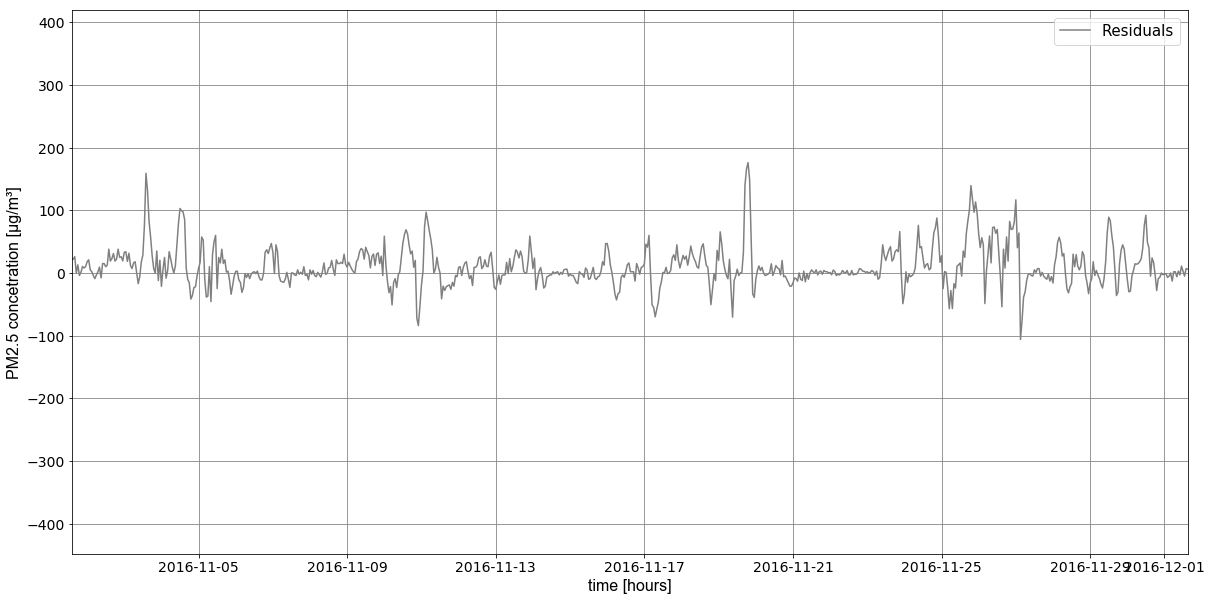

In [158]:
# plot Observations
plt.figure(figsize = (20,10))
plt.plot(y_test_df['PM2.5'], label = 'Observed')

# plot Predictions
plt.plot(y_test_df['PM2.5 - prediction'], color = 'orange', label = 'Predicted')
plt.xlim( '2016-11-1 14:00:00', '2016-12-1 15:00:00')
plt.ylabel('PM2.5 concetration [µg/m³]', fontdict = font_dict)
plt.xlabel('time [hours]', fontdict = font_dict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={"size":15})
plt.grid(True)
plt.rc('grid', linestyle='-', color='grey')
plt.show()

# plot Residuals
plt.figure(figsize = (20,10))
plt.plot(y_test_df['Residuals'], color = 'grey')
plt.xlim( '2016-11-1 14:00:00', '2016-12-1 15:00:00')
plt.ylabel('PM2.5 concetration [µg/m³]', fontdict = font_dict)
plt.xlabel('time [hours]', fontdict = font_dict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={"size":15})
plt.grid(True)
plt.rc('grid', linestyle='-', color='grey')
plt.show()

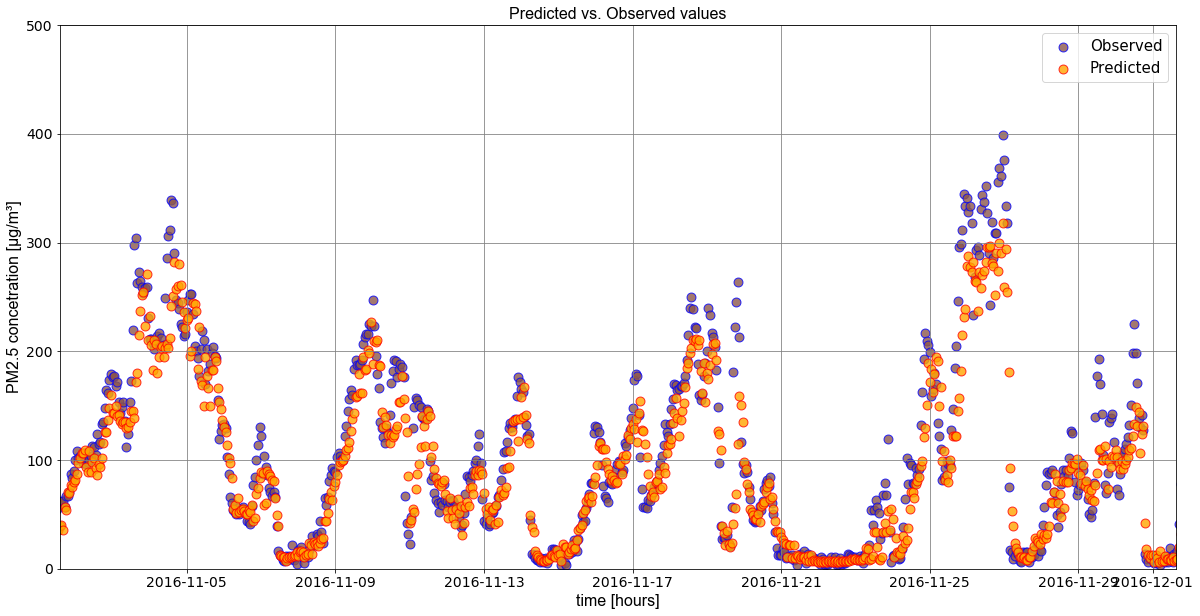

In [23]:
plt.figure(figsize = (20,10))
plt.scatter(y_test_df.index, y_test_df['PM2.5'], color = 'blue',  s=80, facecolors='C5', edgecolors='b', alpha = 0.8, label = 'Observed')
plt.scatter(y_test_df.index, y_test_df['PM2.5 - prediction'], color = 'orange', s=80, facecolors='orange', edgecolors='r', alpha = 0.8, label = 'Predicted')
plt.xlim( '2016-11-1 14:00:00', '2016-12-1 15:00:00')
plt.title('Predicted vs. Observed values', fontdict = font_dict)
plt.ylabel('PM2.5 concetration [µg/m³]', fontdict = font_dict)
plt.xlabel('time [hours]', fontdict = font_dict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={"size":15})
plt.grid(True)
plt.rc('grid', linestyle='-', color='grey')
plt.ylim(0, 500)
plt.show()

The predictions seem to be quite accurate and the residuals indicate a slight underestimation.